# Course Three: Build a Classifier

Expected time to complete: 1 hour.

## Goal of this Course
During this course we will build a regressor to forecast the minutes watched within the last two-week group.

This course is split into the following parts:
- <a href='#context'>Context</a> 
- <a href='#estimation'>Estimate the Parameters</a> 
- <a href='#training_test'>Training and Test Sets</a>
- <a href='#model_selection'>Model Selection</a>
- <a href='#model_evaluation'>Model Evaluation</a>
- <a href='#baseline'>Baseline Score</a>
    - <a href='#load_data'>Load the Data</a>
    - <a href='#def_baseline'>Define a Baseline</a>


- <a href='#decision_tree'>Decision Tree</a>
    - <a href='#training'>Model Training and Hyperparameters Tuning</a>
    - <a href='#best_decision_tree'>Understanding our Best Decision Tree Model</a>


- <a href='#rf'>Random Forest</a>
    - <a href='#training2'>Model Training and Hyperparameters Tuning</a>
    - <a href='#best_rf'>Understanding our Best Random Forest Model</a>
    
    
- <a href='#logistic_reg'>Logistic Regression</a>
    - <a href='#training3'>Model Training and Hyperparameters Tuning</a>
    - <a href='#best_logistic_reg'>Understanding our Best Logistic Regression Model</a>    


- <a href='#svm'>Support Vector Machine</a>
    - <a href='#training4'>Model Training and Hyperparameters Tuning</a>
    - <a href='#best_svm'>Understanding our Best SVM Model</a>



- <a href='#model_perf_comp'>Model Performance Comparison</a>


<a id='context'></a>
# Context

In the previous course we had a look at the process of preparing our dataset so that it can be easily ingested into one of many statistical learning models. We looked at how to identify whether our data is suitable for a supervised or unsupervised learning framework and also the differences between preparing our data for classification or regression models.  

In this course we will introduce key concepts around the use of machine-learning models while demonstrating the way a classification model can be used with a dataset. We will look at the process of choosing the most appropriate model, the way to train it with your data and finally how to evaluate it's performance.

<a id='estimation'></a>
# Estimate the Parameters

As we are in the supervised framework, the objective of each model we use for this project will be to formalise a relationship between the target output _y_ - what we want to forecast, and the the observable features _X_, using more or less complex formulas. These formulas will contain parameters that we need to estimate.

For all algorithms we will minimise the  __loss function__ - this quantifies the distance between our model predictions (with a specific set of parameters) and the correct output _y_. The estimation process can be tricky as we are considering complex relations between our features and output.  Fortunately, we do not need to know much more than this as Python is doing all the maths for us! 

For those interested in learning more about optmisation and, in particular, the popular _gradient descent_ algorithm, there is a nice post here that uses excel to demonstrate: https://www.kdnuggets.com/2017/04/simple-understand-gradient-descent-algorithm.html

<a id='training_test'></a>
# Training and Test Sets
 
When training machine learning models - i.e. estimating their parameters, we want to avoid training the model on all of the possible data that we have available. This is to avoid creating a model that is tuned too specificsally to our training data and will later not generalise - this is often called __overfitting__. 

So, instead we will spilt our data into __training sets__ and __test sets__. We then estimate the parameters of the model using the training sets and then evaluate performance using the test sets.  A popular approach is  __k-fold cross-validation__. Cross-validation is a clever way of carving up our dataset so that we can use all of it for training while still allowing us to evaluate or model using unseen data.   It works by initially splitting the dataset into  _k_ equally-sized sets (or "folds"). Then we loop through each of the _k_ folds of data (*k_i*) and do the following: 

- Remove fold *k_i* and label that the test set.
- Aggregate the remaining *k-1* folds and label that the training set.
- Train the model using the data from the training set. 
- Evaluate the performance (compute the error) of the trained model using data from the test set.

Once we have trained all of our _k_ models we have computed _k_ errors or performance metrics (see the model evaluation part for more details on the metrics used). The average of these errors has been found to be a more robust metric than any of the individual error scores.

For many complex problems and datasets the 'bleeding' of information from the test set into the training set by mistake can be a real problem. In such a case, our model would perform much worse in production than what we would otherwise expect. Very few data scientists have avoided the scenario where initially, they think they have trained a near perfect model and think they are a genius, only to realise later that there was a bug in the code and a leak of information between the training and test set exists.

Tip: if your model performance looks too good to be true - it probably is.

<a id='model_selection'></a>
# Model Selection
 
The first decision you need to make in the model selection process within the supervised framework is whether you plan to use a __classifier__ or a __regressor__ model. As discussed in the previous course, classifiers make discrete predictions about a datapoint into a finite number of classes while regressors make linear predictions.  
 
Different models work in different ways and are more or less suitable for different problems. Fortunately, however,  understanding these specific differences is not essential to solve your data problems. The python module `scikit learn` contains all of the models that you are likely to need and the format of the data it requires is standardised across models. This makes it very easy to try your data using a myriad of different models and choose the one that performs best on your data.
 
In our current project we use both classifiers and regressors to predict engagement. In the classifier we simply try to predict whether someone has watched any content in the two-week period, while in the regressor we attempt to predict the number of minutes watched by the viewer within the two-week period.

We won't tackle both prediction tasks here. This course focuses on classification and the next one will focus on regression.

<a id='model_evaluation'></a>
# Model Evaluation

To evaluate our models there are different metrics we can use. For classifiers, two popular metrics are __accuracy__ (percentage correct) and __the ROC curve__. The accuracy is the simplest metric but it gives us little insight into the behaviour of the model. ROC curves (and __the area under the curve__ statistic) give us a greater understanding of the separability of the data. For more details see https://en.wikipedia.org/wiki/Receiver_operating_characteristic.

We will evaluate our model at different stages in the model selection process. First, when training our model we will compute a test or __out-of-sample error__ (actually _k_ errors after cross-validation). It's known as out-of-sample here because the predictions are made on data the model has never seen before. 

Usually models have also __hyperparameters__ - these are parameters of the learning algorithms we use to train our model (parameters of the parameter-estimators!). To find the best combination of hyperparameters, we usually try many different combinations (or perform a _grid search_ ) and select the combination that yields the lowest error. 

Once we have selected the best set of hyperparameters for a given model, or the best kind of model for the data we have got, we can retrain a new model on the entire dataset and compute its __in-sample__ error, i.e. evaluate its predictions with the observed targets, keeping in mind that we have used this data to build the model this time. 

In many situations the most valid performance metric of a model will be it's out-of-sample error, but on a set of data that has not been used in any of the training phase. It is for this reason that some researchers hold out a further __validation set__ that can only be used to evaluate the model a single time,  once the model has been fully trained and hyperparameters estimated.

Finally, when computing the performance of a model based on a given metric it's important to bare in mind what the performance of the most simple model would be. Usually we consider the completely random one as a baseline. Any model you build must be evaluated in terms of improvement over this performance. 

<a id='baseline'></a>
# Baseline Score

<a id='load_data'></a>
## Load the Data
Now let's dive back into the code. The first thing to do is to get our data back.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt


In [2]:
# We put both target arrays (regression and classification) in the same txt file
# As both target arrays have the same size we just need to split it it two
# and get the correct part for the prediction task
target = np.split(np.loadtxt('target.txt'), 2)[1].flatten()
features = pd.read_csv('features.csv')

# User id as index
features = features.set_index('user_id')

In [3]:
features.head()

,tw_lag7_watched,tw_lag6_watched,tw_lag5_watched,tw_lag4_watched,tw_lag3_watched,tw_lag2_watched,tw_lag1_watched,average_completion,total_sessions,num_genre,...,most_weekday_weekday_1,most_weekday_weekday_2,most_weekday_weekday_3,most_weekday_weekday_4,most_weekday_weekday_5,most_weekday_weekday_6,most_timeday_Afternoon,most_timeday_Evening,most_timeday_Morning,most_timeday_Night
user_id,,,,,,,,,,,,,,,,,,,,,
0001c6,16.679200,0.000000,0.0000,0.000000,0.000000,0.152550,0.000000,0.371496,2,1,...,1,0,0,0,0,0,0,1,0,0
000c1a,0.162867,0.147467,107.0984,145.686233,2.286283,100.487767,132.432083,0.233136,28,5,...,0,0,1,0,0,0,0,0,1,0
001c53,1.866300,0.000000,0.0000,0.000000,1.309867,0.000000,0.000000,0.540923,3,2,...,0,1,0,0,0,0,0,0,1,0
001d44,0.000000,0.000000,0.0000,14.547700,0.000000,0.000000,0.248017,0.058203,2,2,...,0,0,0,0,0,1,0,0,1,0
002b2e,291.477033,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.230264,17,5,...,0,1,0,0,0,0,0,1,0,0


In [4]:
target[:10]

array([ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.])

<a id='def_baseline'></a>
## Define a Baseline

Usually dealing with a binary classification problem (1/0) we talk about __scoring__. The probability of belonging to the class 1 (usually our class of interest) is the score. Alternatively, we can always predict the most common class. This gives the highest possible accuracy without doing any actual classification, but might not make sense for your problem. It's up to you to decide which is most appropriate, but if in doubt, do both.

As previously mentioned, we should always be aware of a baseline to compare the performance of our models with. We usually use as a baseline score the one that would be achieved if we were using a random model.  If, in our random model, we predict all 100/100 users to be in class 1, the accuracy of this model can be calculated as the proportion of class 1 in the entire population of 100. If we observe 30% of actual class 1 users in the population, then we would expect 30 correct predictions labeled class 1 if our model made random predictions.


In [5]:
# Let's check our baseline score
sum(target)/len(target)

0.40551224332930713

In [6]:
# Let's also check the score of the most common class, which given is target class 0
sum(target==0)/len(target)

0.59448775667069287

So for any classification model to add value we would like it to perform with an accuracy of more than 60% (otherwise guessing based on the proportions would be a better model).

We will try 4 different kinds of classification model.

<a id='decision_tree'></a>
# Decision Tree

Decision-trees are one of the most simple to understand classifiers. They work on the assumption that a classification can be made based upon the answers to a series of yes/no questions about the data. When visualised in graph form, this series of questions assume the appearance of a tree, hence the name. The analogy continues with "branches" as answers to questions and "leaves" as the class labels at the end of the branches.

https://en.wikipedia.org/wiki/Decision_tree_learning

For all the models we use the Python `scikit learn` library, as it is really easy to use and well-documented. For decision trees see: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [7]:
# Let's build a simple tree based classification model
from sklearn import tree

# Accuracy as our error evaluation
from sklearn.metrics import accuracy_score

# We will use cross validation, so import helper functions for this
from sklearn.model_selection import cross_val_score, cross_val_predict

<a id='training'></a>
## Model Training and Hyperparameters Tuning
As explained previously, we will do cross-validation during the training process. There is no need to manually split our dataset as `scikit learn` provides a function to do so. 

There are two hyperparameters in decision trees that we need to tune:
- the maximum depth of the tree `max_depth` (default _None_): think of this as the maximum number of questions the model can ask of the data before making a classification;
- the minimum number of samples required to be at a leaf node `min_samples_leaf` (default 1): this value effects the decision of whether a branch node becomes a leaf node or is split into a further two branches.

Here we will keep track of the hyperparameters that maximize the accuracy (or error score). These settings will define our _best decision tree_ model. 

The score returned by our code is the average of the out-of-sample scores computed during the cross-validation process. 

In [8]:
# Setup the model and develop a simple grid search against some key parameters
param_max_depth=[2,3,4,6,8,10]
param_min_leaf=[75,90,100,110,125,150]

In [9]:
# Let's keep track of our best parameters
DTbest_score=0
best_param=[0,0]

# We will use the itertools library to try all the possible combinations of paramaters
# We could also have used the gridsearchCV capability in scikit learn
for c in itertools.product(param_max_depth,param_min_leaf):
    treeclass=tree.DecisionTreeClassifier(max_depth=c[0],min_samples_leaf=c[1])
    scores=cross_val_score(treeclass,
                           features,
                           target,
                           scoring='accuracy')
    if np.mean(scores)>DTbest_score:
        DTbest_score=np.mean(scores)
        best_param=c

# Print the overall best results
print('Best Settings: Max Depth:',best_param[0], '- Min Sample Leaf:',best_param[1])
print('Score:', DTbest_score)

Best Settings: Max Depth: 4 - Min Sample Leaf: 150
Score: 0.791369138705


So this means that we would expect our best decision tree model to correctly classify just under 80% of our users as either engaged or not engaged within our two-week test period, based upon our features from the previous 14 weeks.

<a id='best_decision_tree'></a>
## Understanding our Best Decision Tree Model

Now that we have identified our hyperparameters, it is often helpful to inspect this "best" model to try understand how it is working and discover which features are contributing the most information. To do this, we can train a new model using the entire dataset.

In [10]:
# Let's keep our best model (hyperparameters tuned)
treeclass=tree.DecisionTreeClassifier(max_depth=best_param[0],
                                      min_samples_leaf=best_param[1])
DTmod1=treeclass.fit(features,target)

We can also compute the in-sample accuracy. Remember that the in-sample accuracy is not a good indication of how well the model will generalise as we are evaluating it using the same data that we have trained it on. 

The in-sample accuracy (or inversely the "training error") is a useful metric to compare with the out-of-sample accuracy (or inversely the "test" error). Similar scores for the in-sample and out-of-sample accuracy is a good sign that the model is not overfitting. However, if we see significantly higher performance in the in-sample scores, this is a sign that our model is overfitting the data.

In [11]:
# The model has been trained on the entire dataset - i.e. the output we are comparing our
# predictions with here have been used to estimate the parameters
DTmod1.score(features,target)

0.79598111342923028

So, the in-sample score is very similar to the out-of-sample score, which is a positive sign that the model is not overfitting and is more likely to generalise to unseen data.

To gain a greater insight into how the model is working we can rank our features by their importance to the model. `Scikit learn`  provide a way of doing this by calculating the __Gini importance__ of each feature.  

In [12]:
# Features importance
feature_imp1=pd.DataFrame(
    {'feature': list(features.columns),
     'importance': list(DTmod1.feature_importances_)
    })
feature_imp1.sort_values(by='importance', ascending=False).reset_index(drop=True).head(10)

,feature,importance
0,tw_lag1_watched,0.727607
1,total_sessions,0.108587
2,tw_lag3_watched,0.091046
3,tw_lag2_watched,0.057636
4,tw_lag5_watched,0.012301
5,num_genre,0.002823
6,tw_lag7_watched,0.000000
7,most_weekday_weekday_4,0.000000
8,most_genre_Weather,0.000000
9,most_weekday_weekday_0,0.000000


Here we can see the the most important feature for predicting iPlayer engagement in our target two-week group is the number of minutes viewed in the two previous weeks. The number of sessions within the past 14 weeks is also important, but to a much lesser extent. 

These first  _business_ insights sound sensible and represent an indication that the model is doing what we expect it to. 

<a id='rf'></a>
# Random Forest
A random forest is a collection of decision trees. Single decision trees as documented above are built using the entirety of the training set while random forests generate multiple random subsets from the input data and train different trees with different subsets. Different trees are therefore trained on different samples and different features. Each tree votes for a particular class and the class receiving the most votes wins. 

The concept of _resampling data_ that is at the heart of random forests is common in machine-learning techniques. You may have noticed how cross-validation also uses a resampling technique to make more of the dataset and generate a more robust error score. Random forests are doing something similar. Random forests are also less prone to overfitting than decision trees as the trees they grow tend to be smaller and less complex. 

For more details: https://en.wikipedia.org/wiki/Random_forest <br>

And the `scikit learn` documentation: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [13]:
# Let's build a random forrest
from sklearn.ensemble import RandomForestClassifier

<a id='training2'></a>
## Model Training and Hyperparameters Tuning
We need to tune the same hyperparameters as for a decision tree model:
- the maximum depth of the tree `max_depth` (default _None_);
- the minimum number of samples required to be at a leaf node `min_samples_leaf` (default 1).

In [14]:
# Setup the model and develop a simple grid search against some key parameters
param_max_depth=[2,3,4,6,8,10]
param_min_leaf=[75,90,100,110,125,150]

In [15]:
# Let's keep track of our best parameters
RFbest_score=0
best_param=[0,0]

# We will use the itertools library to try all the possible combinations of paramaters
# We could also have used the gridsearchCV capability in scikit learn
for c in itertools.product(param_max_depth,param_min_leaf):
    forrestclass=RandomForestClassifier(n_estimators=200,
                                        max_depth=c[0],min_samples_leaf=c[1])
    scores=cross_val_score(forrestclass,
                           features,
                           target,
                           scoring='accuracy')
    if np.mean(scores)>RFbest_score:
        RFbest_score=np.mean(scores)
        best_param=c

# Print the overall best results
print('Best Settings: Max Depth:',best_param[0], '- Min Sample Leaf:',best_param[1])
print('Score:', RFbest_score)

Best Settings: Max Depth: 8 - Min Sample Leaf: 75
Score: 0.793564865762



So we see here that the accuracy is very similar to the accuracy achieved by our privious decision tree. This means that, for this particular problem, random forests provide little benefit over a single decision tree.

<a id='best_rf'></a>
## Understanding our Best Random Forest Model

Now that we have identified our best hyperparameters, let's train a new model.

In [16]:
# Let's keep our best model (hyperparameters tuned)
forrestclass=RandomForestClassifier(n_estimators=200,
                                    max_depth=best_param[0],
                                    min_samples_leaf=best_param[1])
RFmod2=forrestclass.fit(features,target)

In [17]:
# In-sample accuracy
RFmod2.score(features,target)

0.8001537279016141

A similar in- and out-of sample accuracy, just like for the decision tree, is a positive indication that the model is not overfitting.

Now let's look at the importance of the features in this model.

In [18]:
# Features importance
feature_imp2=pd.DataFrame(
    {'feature': list(features.columns),
     'importance': list(RFmod2.feature_importances_)
    })
feature_imp2.sort_values(by='importance', ascending=False).reset_index(drop=True).head(10)

,feature,importance
0,tw_lag1_watched,0.230166
1,tw_lag2_watched,0.158738
2,total_sessions,0.123363
3,tw_lag3_watched,0.113696
4,num_weekday,0.106914
5,num_genre,0.089566
6,tw_lag5_watched,0.055339
7,tw_lag4_watched,0.033368
8,num_timeday,0.027238
9,tw_lag6_watched,0.025379


Interestingly, the random forest distributed importance over many more features than the single decision tree did. We still see that the most recent two-week period of views as the most informative but not by so much as we saw in the original decision tree. 

<a id='logistic_reg'></a>
# Logistic Regression

Next let's try a classifier that is not based upon decision trees. Logistic regression is a specialised example of a __generalised linear model__.

Generalised linear models estimate the parameters of the following equation: _y_ = _b1x_ + _b2_ +  _e_ . Here _y_ is the output variable, _x_ is a feature input, _b1_ is a parameter that weights the given input, _b2_ is an additional parameter and is _e_ is the normally-distributed error. If the model has _n_ features, the _b1x_ expression can be replaced by the sum of *x_i...n* *b_i...n*. This is otherwise known as multiple regression.

Logistic regression is a special version of multiple regression as it's output is categorical and not linear. The output of a logistic regression model is turned into a probability (a number between 0 and 1) by passing it through a _logistic function_. This probability then allows us to make a prediction of class assignment.  

Scikit documentation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [19]:
# Let's build a logistic regression
from sklearn import linear_model

<a id='training3'></a>
## Model Training and Hyperparameters Tuning

In the same way that we did with the decision-tree based classifiers, we shall first estimate the hyperparameters. The "C" hyperparameter that we shall estimate here measures the amount of __regularization__ in the model.

When very large numbers are estimated for model parameters, overfitting tends to increase. Regularization is a technique that penalises the size of these estimated parameters during training. In this case the smaller C is, the stronger the regularizarion.

In [20]:
# setup the model and develop a simple grid search against some key parameters
param_C=[0.001,0.01,0.1,1.0,10,100,1000]

In [21]:
# Let's keep track of our best parameters
LRbest_score=0
best_param=0

# we will setup a manual grid search, but you can also use the gridsearchCV capability in sklearn
for i in param_C:
    logclass=linear_model.LogisticRegression(C=i)
    scores=cross_val_score(logclass,
                           features,
                           target,
                           scoring='accuracy')
    if np.mean(scores)>LRbest_score:
        LRbest_score=np.mean(scores)
        best_param=i

# print the overall best results
print('Best Settings: C:',best_param)
print('Score:', LRbest_score)

Best Settings: C: 0.01
Score: 0.774349504645


Now that we have found our optimal combination of hyperparameters, let's evaluate the model using all of the data.

<a id='best_logistic_reg'></a>
## Understanding our Best Logistic Regression Model

In [22]:
# Let's keep our best model (hyperparameters tuned)
logclass=linear_model.LogisticRegression(C=best_param)
LRmod3=logclass.fit(features,target)

In [23]:
# In-sample accuracy
LRmod3.score(features,target)

0.77698473701548254

Like all our previous models the difference between the in-sample accuracy and out-of-sample accuracy is marginal, meaning there is no sign of overfitting and the model will likely generalise well to new data.

To get a better understanding of how our logistic regression model works, we can have a look at the parameter estimates that weight our individual features. We need to be careful though as linear models make certain assumptions about the data they model, which theoretically should be checked _before_ using them. One of these assumptions is that the input variables or features should not be correlated. While a violation of this assumption does not invalidate the model it does make the the parameter estimates uninterpretable.

For more information on the assumption of logistic regression that are beyond the scope of this tutorial: http://www.statisticssolutions.com/assumptions-of-logistic-regression/

In [24]:
# Estimated coefficients
coef_mod3=pd.DataFrame(
    {'feature': list(features.columns),
     'coef': list(LRmod3.coef_.flatten())
    })
coef_mod3.sort_values(by='coef',ascending=False).reset_index(drop=True).head()

,coef,feature
0,0.257713,num_weekday
1,0.112733,num_genre
2,0.006833,tw_lag1_watched
3,0.002636,total_sessions
4,0.002421,tw_lag2_watched


In [25]:
coef_mod3.sort_values(by='coef',ascending=False).reset_index(drop=True).tail()

,coef,feature
29,-0.286905,most_timeday_Afternoon
30,-0.288045,most_genre_Factual
31,-0.292455,most_genre_Drama
32,-0.307663,most_timeday_Night
33,-0.398026,most_timeday_Evening


For the estimated coefficients we should also in theory have a look at the __p-values__ - statistic values that indicate whether our estimated coefficient is significantly different from zero. We won't go more into details here.

The logistic regression framework seems also less suited for our data than the decision tree according to the training and testing performances. 

<a id='svm'></a>
# Support Vector Machine

A support vector machine (SVM) is yet another type of classifier that can be used to predict categorical output variables. Put simply, SVMs search for the _hyperplane_ (think of a high-dimensional straight line) that maximises the distances between the two classes. 

For more about SVMs: 
Scikit documentation: http://scikit-learn.org/stable/modules/svm.html

http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

In [26]:
# Let's try to get some non linear patterns
from sklearn import svm

<a id='training4'></a>
## Model Training and Hyperparameters Tuning

Like before, we need to tune the hyperparameters of our model. For this SVM we will tune just a single hyperparameter: "C". 

This value tells our SVM how much we care about avoiding misclassification of each datapoint in the training data. For smaller C values, the model will choose a hyperplane with a larger margin between the two classes - but as a result will misclassify more points. Conversely for larger C values, the model will chose a hyperplane with a smaller margin between the two classes - so therefore likely to make fewer misclassifications.

In [27]:
# setup the model and develop a simple grid search against some key parameters
param_C=[0.001,0.01,0.1,1.0,10,100,1000]

In [28]:
# Let's keep track of our best parameters
SVMbest_score=0
best_param=0

# we will setup a manual grid search, but you can also use the gridsearchCV capability in sklearn
for i in param_C:
    svcclass=svm.SVC(C=i, kernel='rbf')
    scores=cross_val_score(svcclass,
                           features,
                           target,
                           scoring='accuracy')
    if np.mean(scores)>SVMbest_score:
        SVMbest_score=np.mean(scores)
        best_param=i

# print the overall best results
print('Best Settings: C:',best_param)
print('Score:', SVMbest_score)

Best Settings: C: 1.0
Score: 0.704292079161


<a id='best_svm'></a>
## Understanding our Best SVM Model
Like on all previous models, we now train our SVM on the all of the data to evaluate it further.

Unfortunately, SVMs are relatively opaque, when it comes to interpreting the contributions of the different features in our model. However, to get an idea of how well it is fitted to our data, we can still calculate the in-sample performance.

In [29]:
# Let's keep our best model (hyperparameters tuned)
svcclass=svm.SVC(C=best_param, kernel='rbf')
SVMmod4=svcclass.fit(features,target)

In [30]:
# In-sample error
SVMmod4.score(features,target)

0.94279125947073683

In this instance, we can see that the in-sample performance is significantly higher than the out-of-sample performance. As we have discussed previously, this is a bad sign and an indication that the dreaded overfitting has ocurred meaning the model will struggle to generalise well to unseen data. 

When models do not fit correctly, there are usually steps we can take to adapt the data to the model or adapt the model to the data. For the former, SVM's usually benefit significantly from __a normalisation__ of their input (transforming the features to "z-scores" of themselves), so this would be a logical next step to imporve performance.

For the latter we could take a further look at the hyperparameters - we could try a finer gridsearch of the values closest to our current best value and we could also look at using a different type of _kernel_. The current kernel we are using is a non-linear one. Using a non-linear kernel makes non-linear classification problems solvable (the original linear SVM can only solve linearly sepearable classes) but also increases the complexity of the model and therefore the potential for overfitting.

Exploring these possibilities are beyond the scope of this tutorial but the reader is encouraged to explore them themselves to see if they can fit a better SVM model. 

<a id='model_perf_comp'></a>
# Model Performance Comparison

Now that we have trained four models with our dataset, let's visualise their results.

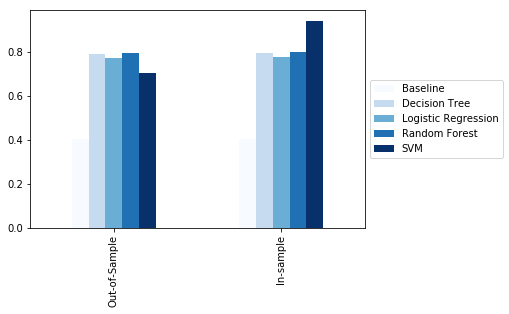

In [31]:
scores = pd.DataFrame({'Baseline':[sum(target)/len(target), sum(target)/len(target)],
                       'Decision Tree':[DTbest_score, DTmod1.score(features,target)], 
                       'Random Forest':[RFbest_score, RFmod2.score(features,target)],
                       'Logistic Regression':[LRbest_score, LRmod3.score(features,target)], 
                       'SVM':[SVMbest_score, SVMmod4.score(features,target)] },
                      index=['Out-of-Sample','In-sample'])

scores.plot(kind='bar', colormap='Blues')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

So, to summarise our results we can see that all of our models with, the exception of the SVM, have similar performance for in-sample and out-of sample tests. This is a good indication that those models are well-fitted and have identified the latent structure that we are interested in.

For our SVM classifier, as the out-of-sample performance is much lower than the in-sample performance, we can assume that this model is not well-fitted and, without, further tuning is not a good choice to use with new data.

The decision-tree and the random forest models were essentially indistinguishable in their out-of-sample accuracy while the logistic regression model performance was marginally lower than them both. 

# Summary

In this course we have used a group of statistical learning models called classifiers. 
- We discussed how training a model is equivalent to estimating parameters.  
- We discussed the importance of cross-validation - splitting our dataset into training sets (for parameter estimation) and test sets (for model evaluation). This process reduces the likelihood of overfitting: the phenomenon whereby our model is tuned to the idiosynchrasies of the our training data - not the latent structure we are trying to model, and therefore fails to generalise when it sees new data.
- We discussed how models can have different hyperparameters and how these can be estimated.
- Finally, we used our data to train and introduce four specific classifier models. We walked through the process of hyperparameters selection and the significance of the difference between in-sample and out-of-sample performance.

In the next course we will have a look at a different class of statistical learning models: regressors.